# 1. Setup and Configuration

In [108]:
# Install Kaggle API tool
!pip install kaggle

# Environment configuration for Kaggle in Colab
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"
!mkdir -p /content/.kaggle
!cp kaggle.json /content/.kaggle/

In [109]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings

# Configuration
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [110]:
# Define color palette for consistency
colors = ['#002F5F', '#FDB813', '#F37021', '#7B1E3B', '#005B4F']

# 2. Load and Inspect the Dataset

In [111]:
# Download and extract dataset
!kaggle datasets download -d ealaxi/paysim1
!unzip -q /content/paysim1.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/PS_20174392719_1491204439457_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [112]:
# Load dataset
df = pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')
print("Initial shape:", df.shape)
df.head()

Initial shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [113]:
# Basic inspection
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


## **Variable Descriptions**
- `step` - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- `type` - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- `amount` -
amount of the transaction in local currency.

- `nameOrig` - customer who started the transaction

- `oldbalanceOrg` - initial balance before the transaction

- `newbalanceOrig` - new balance after the transaction.

- `nameDest` - customer who is the recipient of the transaction

- `oldbalanceDest` - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- `newbalanceDest` - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- `isFraud` - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- `isFlaggedFraud` - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 3. Data Cleaning and Type Casting

In [114]:
# Rename misnamed columns
df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'}, inplace=True)

# Convert column types to reduce memory
df['type'] = df['type'].astype('category')
df['isFraud'] = df['isFraud'].astype(np.int8)
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(np.int8)
df['nameOrig'] = df['nameOrig'].astype('string')
df['nameDest'] = df['nameDest'].astype('string')
df['amount'] = df['amount'].astype(np.float32)  # reduce from float64 to float32

In [115]:
# Add customer type information based on account ID prefix
df['orgType'] = df['nameOrig'].str[0].map({'M': 'Merchant', 'C': 'Customer'}).fillna('Other').astype('category')
df['destType'] = df['nameDest'].str[0].map({'M': 'Merchant', 'C': 'Customer'}).fillna('Other').astype('category')

# 4. Exploratory Data Analysis (EDA)

## Confusion Matrix for Fraud Flagging

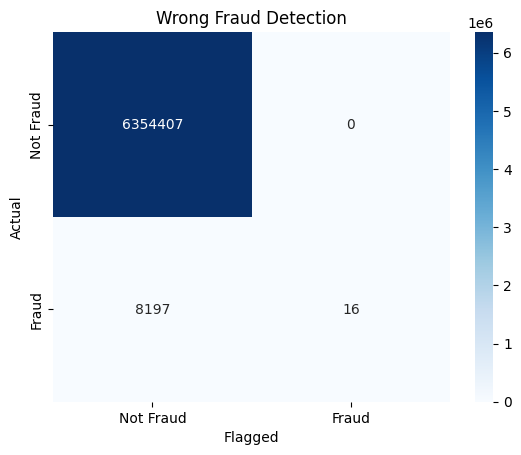

In [116]:
cm = confusion_matrix(df['isFraud'], df['isFlaggedFraud'])

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel('Flagged')
plt.ylabel('Actual')
plt.title('Wrong Fraud Detection')
plt.show()

## Donut Chart: All Transactions by Type

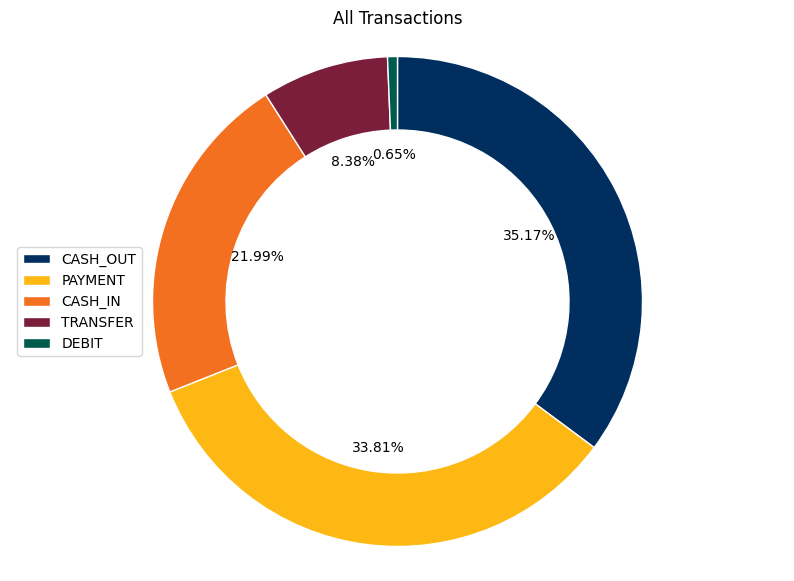

In [126]:
counts = df['type'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(counts, colors=colors, startangle=90, counterclock=False,
        autopct='%1.2f%%', wedgeprops={'width': 0.3, 'edgecolor': 'white'})
plt.title('All Transactions')
plt.legend(labels=counts.index, loc='center left')
plt.axis('equal')
plt.show()


## Donut Chart: Fraudulent Transactions by Type

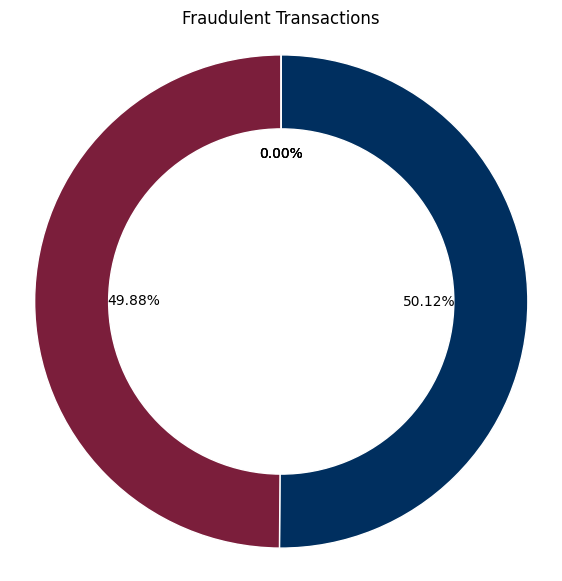

In [127]:
fraud_trans = df[df['isFraud'] == 1]
counts = fraud_trans['type'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(counts, colors=[colors[0], colors[3]], startangle=90, counterclock=False,
        autopct='%1.2f%%', wedgeprops={'width': 0.3, 'edgecolor': 'white'})
plt.title('Fraudulent Transactions')
plt.axis('equal')
plt.show()

## Density Plot: Fraud Amounts

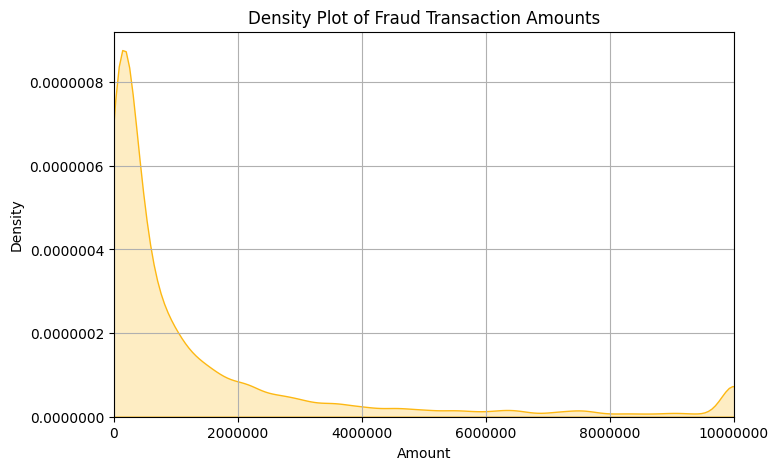

In [128]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=fraud_trans, x='amount', shade=True, color=colors[1], bw_adjust=0.5)
plt.title('Density Plot of Fraud Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.xlim(0, fraud_trans['amount'].quantile(0.99))
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.show()

## Stacked Bar: Destination Types (Fraud vs Non-fraud)

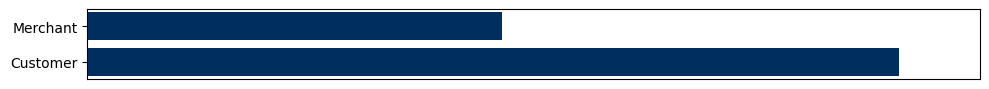

['Customer', 'Merchant'] [np.int64(4211097), np.int64(2151495)]
['Customer', 'Merchant'] [np.int64(28), np.int64(0)]


In [153]:
all_counts = df['destType'].value_counts()
fraud_counts = fraud_trans['destType'].value_counts()
types = ['Customer', 'Merchant']
all_values = [all_counts.get(t, 0) for t in types]
fraud_values = [fraud_counts.get(t, 0) for t in types]
nonfraud_values = [all_values[i] - fraud_values[i] for i in range(len(types))]

# Calculate max total to set axis limit
max_val = max([n + f for n, f in zip(nonfraud_values, fraud_values)])

plt.figure(figsize=(10, 1))
plt.barh(types, nonfraud_values, color=colors[0], label='Non-Fraud')
plt.barh(types, fraud_values, left=nonfraud_values, color=colors[1], label='Fraud')
plt.xticks([])
plt.xlim(0, max_val * 1.1)  # Add space on the right
plt.tight_layout()
plt.show()

print(types, nonfraud_values)
print(types, fraud_values)

8197 customers of fraudulent trans

## Per-Customer Behavior Analysis

In [121]:
# Group by nameOrig for fraud and non-fraud transactions
fraud = df[df['isFraud'] == 1].groupby('nameOrig').size().to_frame(name='fraud').reset_index()
non = df[df['isFraud'] == 0].groupby('nameOrig').size().to_frame(name='non').reset_index()

# Merge and fill missing values
per_customer = pd.merge(fraud, non, on='nameOrig', how='left').fillna(0)

# Ensure memory-efficient types
per_customer['fraud'] = per_customer['fraud'].astype(np.int16)
per_customer['non'] = per_customer['non'].astype(np.int16)

# Add total transactions and label those with both fraud & valid transactions
per_customer['total'] = per_customer['fraud'] + per_customer['non']
per_customer['once_labeled'] = per_customer['fraud'] < per_customer['total']

per_customer.head()

,nameOrig,fraud,non,total,once_labeled
0,C1000036340,1,0,1,False
1,C1000086512,1,0,1,False
2,C1000331499,1,0,1,False
3,C1000484178,1,0,1,False
4,C1000513158,1,0,1,False


### Filter Relevant Transactions

In [122]:
# Customers with at least one valid transaction before being labeled fraud
once_cust = per_customer[per_customer['once_labeled']]['nameOrig'].tolist()

# Subset data to those customers and exclude Merchants as destination
once_trans = df[df['nameOrig'].isin(once_cust)]
once_trans = once_trans[once_trans['destType'] != 'Merchant']
once_trans = once_trans.sort_values(['nameOrig', 'step'])

### Insight: Valid Before Fraud

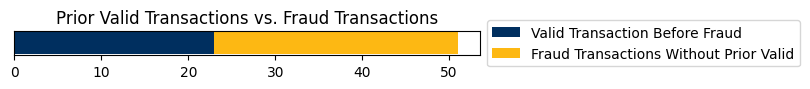

In [139]:
bar_height = 0.2
plt.figure(figsize=(10, 1))
plt.barh(
    ['Once-Labeled Customers'],
    [valid_before_fraud_customers],
    color=colors[0],
    label='Valid Transaction Before Fraud',
    height=bar_height
)
plt.barh(
    ['Once-Labeled Customers'],
    [total_fraud_transactions - valid_before_fraud_customers],
    left=[valid_before_fraud_customers],
    color=colors[1],
    label='Fraud Transactions Without Prior Valid',
    height=bar_height
)

plt.title('Prior Valid Transactions vs. Fraud Transactions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.yticks([])  # This hides Y-axis ticks and labels
plt.show()


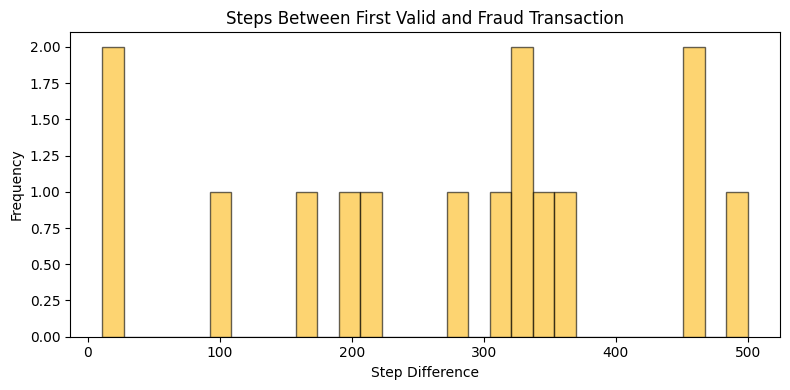

In [145]:
valid_trans = once_trans[once_trans['isFraud'] == 0]
fraud_trans = once_trans[once_trans['isFraud'] == 1]

# Get earliest valid transaction per customer
valid_steps = valid_trans.groupby('nameOrig')['step'].min().reset_index()
valid_steps.columns = ['nameOrig', 'first_valid_step']

# Get fraud transaction step per customer
fraud_steps = fraud_trans[['nameOrig', 'step']].rename(columns={'step': 'fraud_step'})

# Merge both to compute difference
step_diff = pd.merge(fraud_steps, valid_steps, on='nameOrig', how='inner')
step_diff['step_between'] = step_diff['fraud_step'] - step_diff['first_valid_step']
step_diff = step_diff[step_diff['step_between'] >= 0]  # Optional: only positive gaps

# Plot histogram of step differences
plt.figure(figsize=(8, 4))
plt.hist(step_diff['step_between'], bins=30, color=colors[1], edgecolor='black', alpha=0.6)  # alpha added here
plt.title('Steps Between First Valid and Fraud Transaction')
plt.xlabel('Step Difference')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain')  # disable scientific notation
plt.tight_layout()
plt.show()
